In [ ]:
import numpy as np
import pickle
import cv2
import tensorflow as tf
from os import listdir
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
# from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
# from keras.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.applications import InceptionV3

import tensorflow as tf
import matplotlib.pyplot as plt
tf.compat.v1.set_random_seed(0)
from tensorflow import keras
import numpy as np
np.random.seed(0)
import itertools
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
directory_root = '/content/drive/MyDrive/plantvillage dataset'
cnn_model_path = '/content/drive/MyDrive/plantvillage dataset'

In [ ]:
epochs = 50
lr = 1e-3
bs = 32
default_image_size = tuple((256, 256))
image_size = 0
width=256
height=256
depth=3

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Parallelize Image Loading using concurrent futures

In [ ]:
from concurrent.futures import ThreadPoolExecutor

image_list, label_list = [], []

def process_image(image_path):
    try:
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else:
            return None
    except Exception as e:
        print(f"Error: {e}")
        return None

try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)

    for directory in root_dir:
        # remove .DS_Store from list
        if directory == ".DS_Store":
            root_dir.remove(directory)

    with ThreadPoolExecutor() as executor:
        for plant_folder in root_dir:
            plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
            print("checking: ", directory_root, ",", plant_folder,)

            for disease_folder in plant_disease_folder_list:
                # remove .DS_Store from list
                if disease_folder == ".DS_Store":
                    plant_disease_folder_list.remove(disease_folder)

            for plant_disease_folder in plant_disease_folder_list:
                print(f"[INFO] Processing {plant_disease_folder} ...")
                plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

                for single_plant_disease_image in plant_disease_image_list:
                    if single_plant_disease_image == ".DS_Store":
                        plant_disease_image_list.remove(single_plant_disease_image)

                image_paths = [f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}" for image in plant_disease_image_list[:200]]
                results = list(executor.map(process_image, image_paths))

                for result in results:
                    if result is not None:
                        image_list.append(result)
                        label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
checking:  /content/drive/MyDrive/plantvillage dataset , color
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Peach___Bacterial_spot ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Squash___Powdery_mildew ...
[INFO] Processing Cherry_(including_sour)___Powdery_mildew ...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Grape___Esca_(Black_Measles) ...
[INFO] Processing Pepper,_bell___Bacterial_spot ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Tomato___Leaf_Mold ...
[INFO] Processing Tomato___Spider_mites Two-spotted_spider_mite ...
[INFO] Processing Tomato___Target_Spot ...
[INFO] Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus ...
checking:  /content/drive/MyDrive/plantvillage dataset , grayscale
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Corn_(maize)__

In [ ]:
image_list[0]

array([[[ 83.,  81.,  87.],
        [ 83.,  81.,  87.],
        [ 80.,  78.,  84.],
        ...,
        [145., 143., 155.],
        [166., 164., 176.],
        [149., 147., 159.]],

       [[ 80.,  78.,  84.],
        [ 81.,  79.,  85.],
        [ 78.,  76.,  82.],
        ...,
        [157., 155., 167.],
        [163., 161., 173.],
        [163., 161., 173.]],

       [[ 77.,  75.,  81.],
        [ 77.,  75.,  81.],
        [ 75.,  73.,  79.],
        ...,
        [154., 152., 164.],
        [151., 149., 161.],
        [169., 167., 179.]],

       ...,

       [[100.,  96., 101.],
        [102.,  98., 103.],
        [105., 101., 106.],
        ...,
        [234., 230., 235.],
        [222., 218., 224.],
        [212., 208., 214.]],

       [[100.,  96., 101.],
        [102.,  98., 103.],
        [104., 100., 105.],
        ...,
        [215., 209., 214.],
        [219., 212., 219.],
        [216., 208., 218.]],

       [[100.,  96., 101.],
        [102.,  98., 103.],
        [104., 1

In [ ]:
label_list[0]

'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [ ]:
len(np_image_list)

3981

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

In [ ]:
len(x_train)

3184

In [ ]:
len(x_test)

797

Data augmentation

In [ ]:
aug = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 85, 85, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=bs),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // bs,
    epochs=epochs, verbose=1
)

Epoch 1/50
99/99 [==============================] - 78s 641ms/step - loss: 0.5133 - accuracy: 0.1789 - val_loss: 2.0918 - val_accuracy: 0.0414
Epoch 2/50
99/99 [==============================] - 53s 530ms/step - loss: 0.1406 - accuracy: 0.4178 - val_loss: 2.3118 - val_accuracy: 0.0652
Epoch 3/50
99/99 [==============================] - 54s 542ms/step - loss: 0.1161 - accuracy: 0.5168 - val_loss: 0.6853 - val_accuracy: 0.0376
Epoch 4/50
99/99 [==============================] - 52s 527ms/step - loss: 0.1167 - accuracy: 0.5489 - val_loss: 0.6013 - val_accuracy: 0.0678
Epoch 5/50
99/99 [==============================] - 51s 515ms/step - loss: 0.1149 - accuracy: 0.5850 - val_loss: 0.9338 - val_accuracy: 0.1481
Epoch 6/50
99/99 [==============================] - 53s 531ms/step - loss: 0.1458 - accuracy: 0.4978 - val_loss: 0.1958 - val_accuracy: 0.4304
Epoch 7/50
99/99 [==============================] - 53s 531ms/step - loss: 0.1054 - accuracy: 0.6390 - val_loss: 0.1587 - val_accuracy: 0.4780

In [ ]:
final_training_accuracy = history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_accuracy'][-1]

final_training_loss = history.history['loss'][-1]
final_validation_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_training_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_validation_accuracy * 100:.2f}%")
print(f"Final Training Loss: {final_training_loss:.4f}")
print(f"Final Validation Loss: {final_validation_loss:.4f}")

Final Training Accuracy: 90.04%
Final Validation Accuracy: 73.15%
Final Training Loss: 0.0309
Final Validation Loss: 0.1173


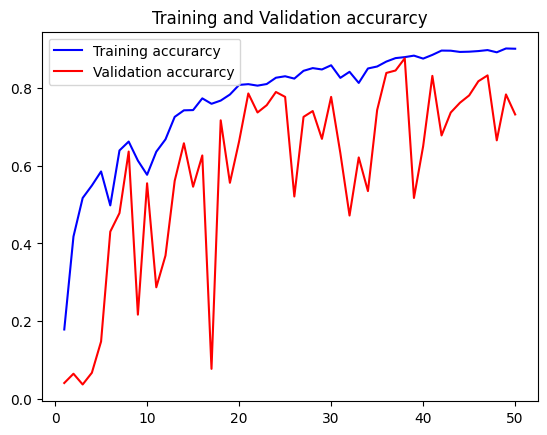

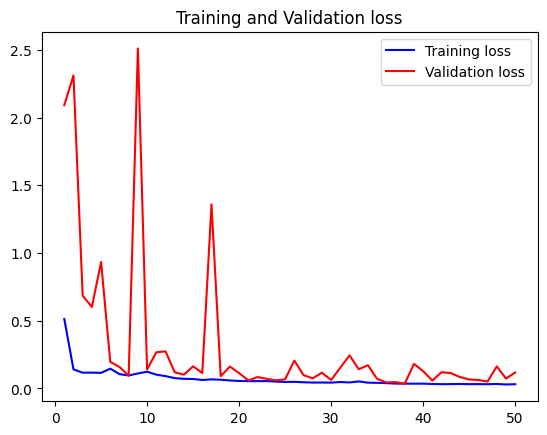

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

takes images as input and output is the disease name

Enter the image file path: /content/drive/MyDrive/plantvillage dataset/color/Apple___Black_rot/0139bc6d-391c-4fd1-bcae-cc74dabfddd7___JR_FrgE.S 2734.JPG


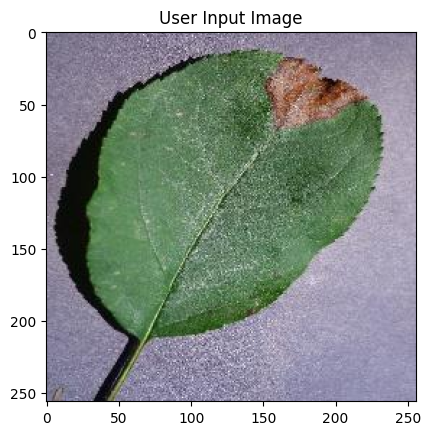

1/1 [==============================] - 0s 31ms/step
Predicted Disease name: Apple___Black_rot


In [ ]:
user_image_path = input("Enter the image file path: ")

# Load and preprocess the user input image
user_image = cv2.imread(user_image_path)
user_image = cv2.resize(user_image, (256, 256))
user_image = user_image.astype(np.float16) / 255.0
user_image = np.expand_dims(user_image, axis=0)

# Display the user input image
plt.imshow(cv2.cvtColor(cv2.imread(user_image_path), cv2.COLOR_BGR2RGB))
plt.title("User Input Image")
plt.show()

predictions = model.predict(user_image)
predicted_class = label_binarizer.classes_[np.argmax(predictions)]

# Output the predicted disease
output_file_path = '/content/drive/MyDrive/plantvillage dataset/predicted_disease.txt'
with open(output_file_path, 'w') as file:
    file.write(f"Predicted Disease: {predicted_class}")

print(f"Predicted Disease name: {predicted_class}")


In [ ]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open(cnn_model_path +'/cnn_model.pkl', 'wb'))

[INFO] Saving model...


#Lime

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=5c5ac7f5d82e6488e5bb3b370295e8326b4877e98bd201d7afcd7fd03e823244
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
# loaded_model = pickle.load(open(cnn_model_path + '/cnn_model.pkl', 'rb'))

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


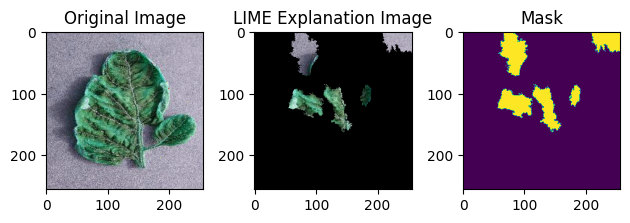

In [ ]:
import lime
from lime import lime_image

num_samples = len(x_test)
x = random.randint(0, num_samples - 1)

# Create the LimeImageExplainer
explainer = lime_image.LimeImageExplainer(random_state=42)

# Explain the instance
explanation = explainer.explain_instance(
    x_test[x],
    model.predict,
    top_labels=2,
    hide_color=0,
    num_samples=1000
)

# Get the image and mask for the explanation
image, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    hide_rest=True
)

# Display the images
plt.subplot(1, 3, 1)
plt.imshow((x_test[x] * 255).astype(np.uint8))
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(image)
plt.title("LIME Explanation Image")

plt.subplot(1, 3, 3)
plt.imshow(mask)
plt.title("Mask")

plt.tight_layout()
plt.show()
